In [2]:
import numpy as np
import cv2
import os
import pickle
from math import *
from glob import glob
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML, display

In [3]:
visualization = []
class VisualClass():
    
    def __init__(self, k, norm):
        
        self.k = k
        self.normalize = norm
        self.size = (150, 150)
        self.classes = {1:'aquarium', 2:'desert', 3:'highway', 4:'kitchen', 5:'laundry', 6:'park', 7:'waterfall', 8:'windmill'}
#         self.paths = ['./../dataset/SUN_data/train/aquarium/']
        self.paths = ['./../dataset/SUN_data/train/aquarium/',
                      './../dataset/SUN_data/train/desert/',
                      './../dataset/SUN_data/train/highway/',
                      './../dataset/SUN_data/train/kitchen/',
                      './../dataset/SUN_data/train/laundry/',
                      './../dataset/SUN_data/train/park/',
                      './../dataset/SUN_data/train/waterfall/',
                      './../dataset/SUN_data/train/windmill/']
#         self.testPaths = ['./../dataset/SUN_data/test/aquarium/']
        self.testPaths = ['./../dataset/SUN_data/test/aquarium/',
                      './../dataset/SUN_data/test/desert/',
                      './../dataset/SUN_data/test/highway/',
                      './../dataset/SUN_data/test/kitchen/',
                      './../dataset/SUN_data/test/laundry/',
                      './../dataset/SUN_data/test/park/',
                      './../dataset/SUN_data/test/waterfall/',
                      './../dataset/SUN_data/test/windmill/']
    
    '''
    Dense SIFT from scratch
    '''

    def PP(self, shape=(150,150),l=32,s=16): # PP is patch points - centre of the patches taken
    
        x = np.arange((l-1)//2,shape[1]-(l-1)//2-1,s)
        y = np.arange((l-1)//2,shape[0]-(l-1)//2-1,s)
        x,y = np.meshgrid(x,y)
        kp = np.vstack((x.flatten(),y.flatten(),((x-x+1)*l).flatten())).T

        return kp.tolist() 
    
    
    def dense_SIFT_kp(self, shape=(150,150)):

        lis = []
        lis.extend(self.PP(shape,l=10,s=15))
        lis.extend(self.PP(shape,l=15,s=20))
        lis.extend(self.PP(shape,l=25,s=20))

        kp = []
        for a,b,c in lis:
            kp1 = cv2.KeyPoint(a,b,c)
            kp.append(kp1)
            
        return kp

    def sift_features(self, img):
        
        kp = self.dense_SIFT_kp()
        sift = cv2.SIFT_create()
        img = cv2.imread(img, 0)
        img = cv2.resize(img, (150,150))
        _ , vects = sift.compute(img, kp)

        return vects
        
    def get_image_paths(self, train = True):
        
        allImages = []
        
        if train:
            for path in self.paths:
                for image in glob(path + "*"):
                    allImages.append(image)
        
        else:
            for path in self.testPaths:
                for image in glob(path + "*"):
                    allImages.append(image)            
            
        return allImages
    
    def get_sift_descriptor(self, imgPath):
        
        image = cv2.imread(imgPath, 0) #greyscale
        image = cv2.resize(image, self.size, interpolation = cv2.INTER_AREA)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(image, None)

        return keypoints, descriptors

    def get_clusters(self, descriptors):
        
        st = time.time()
        kmeans = KMeans(n_clusters = self.k, random_state = 0).fit(descriptors)
#         kmeans = MiniBatchKMeans(n_clusters = self.k, random_state = 0, batch_size = 128).fit(descriptors)
        et = time.time()
        print(f"time taken to cluster into {self.k} clusters: {et - st}")
        
        return kmeans
    
    def get_normalized(self, words):
        
        normalizedHistogram = np.zeros(self.k, dtype = np.float32)
        cat, count = np.unique(words, return_counts = True)
        count = np.array(count, dtype = np.float32)
        if self.normalize:
            count = count / sum(count)
            count = np.nan_to_num(count, nan = 0.0)
        for idx, word in enumerate(cat):
            normalizedHistogram[word] = count[idx] 
        return normalizedHistogram

    def get_histograms_labels(self, kmeans, train = True):
        
        global visualization
        hist = []
        lbls = []
        lbl = 0
        
        if train:
            PATH = self.paths
        else:
            PATH = self.testPaths
            
        for path in PATH:
            print(lbl := lbl + 1)
            for image in glob(path + "*"):
                descriptors = []
                kp, des = self.get_sift_descriptor(image)
                try:
                    for d in des:
                        descriptors.append(d)
                except:
                    continue
                descriptors = np.asarray(descriptors)
                normalizedHistogram = self.get_normalized(kmeans.predict(descriptors))
                visualization.append(normalizedHistogram)
                hist.append(normalizedHistogram.tolist())
                lbls.append(lbl)
        return hist, lbls

    def train_classifier(self, words, labels):
        
        words = np.asarray(words)
        labels = np.asarray(labels).reshape(-1,1)
        print(f"training histograms: {words.shape}, shape of labels: {labels.shape}")
#         clf = OneVsRestClassifier(SVC(kernel='linear')).fit(words, labels)
        clf = OneVsRestClassifier(SVC(kernel='rbf')).fit(words, labels)
        
        return clf
    
    def get_descriptors(self, train = True):
        
        st = time.time()
        descriptors = []
        imagePaths = self.get_image_paths(train)
        
        for iP in imagePaths:
#             des = self.sift_features(iP) #DenseSIFT
            _, des = self.get_sift_descriptor(iP)
            try:
                for d in des:
                    descriptors.append(d)
            except: 
                continue
        
        descriptors = np.asarray(descriptors)
        et = time.time()
        print("time taken to extract descriptors:", et - st)     
        return descriptors
        
    
    def test(self, kmeans, clf):
        
        confusionMatrix = np.zeros((8,8))
        descriptors = self.get_descriptors(train = False)
        histograms, labels = self.get_histograms_labels(kmeans, train = False)
        histograms = np.array(histograms)
        preds = clf.predict(histograms)
        incorrectlyClassified = [] # image number, prediction, actual
        for prediction in range(len(preds)):
            confusionMatrix[labels[prediction] - 1][preds[prediction] - 1] += 1
            if(labels[prediction] != preds[prediction]):
                incorrectlyClassified.append((prediction, (labels[prediction], preds[prediction])))
#         print(np.unique(preds, return_counts = True))
        print(f"The F1 score for the classifier is {f1_score(labels, preds, average = 'macro')}")
        print(f"The accuracy of the classifier is {accuracy_score(labels, preds)}")
        print(f"The confusion matrix: \n {confusionMatrix}")
        return incorrectlyClassified
        
    def method(self):
        
        descriptors = self.get_descriptors()
        kmeans = self.get_clusters(descriptors)
        histograms, labels = self.get_histograms_labels(kmeans)
        
        clf = self.train_classifier(histograms, labels)
        
        return self.test(kmeans, clf)
        
    


## Observations

We perform the classification multiple times and vary various hyper parameters in each iteration (ex - 'k' in k-means, normalized histogram or not, kmeans or MiniBatchKMeans just to name a few).

We observe that although the computation time for MiniBatchKMeans with batch size as 128 (2^7) is significantly faster (40 - 50 times faster), it yeilds worse classification results when compared to the standard Kmeans. Similarly, we observe that classification is performed better on normalized histograms so we present results for varying the hyper paramter 'k' using the kmeans function and normalized histograms. We find k = 150 to be an optimal value for the number of visual words for this dataset.

We experimentally that the optimal value for the number of clusters is 150.

We're required to use a linear kernal but we also experiment with the more popular rbf kernal.

In [18]:
normHistClass = VisualClass(150, norm = True)
incorrectlyClassifiedNormalized = normHistClass.method()

time taken to extract descriptors: 3.825451135635376
time taken to cluster into 150 clusters: 411.7808520793915
1
2
3
4
5
6
7
8
training histograms: (640, 150), shape of labels: (640, 1)
time taken to extract descriptors: 1.0721371173858643
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.4139768583901655
The accuracy of the classifier is 0.4375
The confusion matrix: 
 [[17.  1.  1.  0.  0.  1.  0.  0.]
 [ 3. 12.  0.  2.  0.  0.  1.  2.]
 [ 1. 10.  3.  1.  2.  1.  0.  2.]
 [ 4.  1.  1.  8.  4.  2.  0.  0.]
 [ 1.  1.  0.  6.  8.  2.  1.  1.]
 [ 6.  0.  0.  1.  0. 11.  1.  1.]
 [ 4.  1.  0.  2.  1.  3.  8.  1.]
 [ 3.  5.  3.  3.  0.  1.  2.  3.]]


In [24]:
normHistClass = VisualClass(150, norm = True)

'''
RBF kernel
'''

incorrectlyClassifiedNormalized = normHistClass.method()

time taken to extract descriptors: 3.930964231491089
time taken to cluster into 150 clusters: 413.1388761997223
1
2
3
4
5
6
7
8
training histograms: (640, 150), shape of labels: (640, 1)
time taken to extract descriptors: 1.1277637481689453
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.521635836865818
The accuracy of the classifier is 0.5375
The confusion matrix: 
 [[16.  0.  0.  0.  1.  2.  0.  1.]
 [ 2. 14.  1.  0.  1.  0.  1.  1.]
 [ 1.  5.  8.  1.  1.  1.  1.  2.]
 [ 3.  1.  1. 10.  3.  1.  0.  1.]
 [ 2.  1.  0.  6.  9.  0.  1.  1.]
 [ 3.  0.  0.  1.  0. 14.  1.  1.]
 [ 2.  0.  0.  2.  0.  3. 12.  1.]
 [ 2.  6.  2.  1.  2.  1.  3.  3.]]


In [26]:
normHistClass = VisualClass(200, norm = True)

'''
RBF kernel
'''

incorrectlyClassifiedNormalized = normHistClass.method()

time taken to extract descriptors: 5.043799161911011
time taken to cluster into 200 clusters: 446.9779920578003
1
2
3
4
5
6
7
8
training histograms: (640, 200), shape of labels: (640, 1)
time taken to extract descriptors: 0.9756238460540771
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.4538349261903074
The accuracy of the classifier is 0.475
The confusion matrix: 
 [[13.  1.  0.  1.  1.  2.  0.  2.]
 [ 2. 15.  0.  1.  1.  0.  1.  0.]
 [ 1.  4.  5.  4.  1.  1.  2.  2.]
 [ 2.  2.  1. 11.  1.  2.  1.  0.]
 [ 2.  1.  1.  8.  7.  0.  1.  0.]
 [ 1.  0.  0.  0.  0. 14.  3.  2.]
 [ 5.  0.  1.  0.  0.  4.  8.  2.]
 [ 3.  6.  1.  2.  0.  3.  2.  3.]]


In [19]:
HistClass = VisualClass(150, norm = False)
incorrectlyClassified = HistClass.method()


time taken to extract descriptors: 4.277925968170166
time taken to cluster into 150 clusters: 412.3886065483093
1
2
3
4
5
6
7
8
training histograms: (640, 150), shape of labels: (640, 1)
time taken to extract descriptors: 1.1805388927459717
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.40909576058317476
The accuracy of the classifier is 0.41875
The confusion matrix: 
 [[14.  0.  1.  1.  1.  2.  0.  1.]
 [ 1. 11.  1.  0.  2.  0.  4.  1.]
 [ 0.  5.  8.  2.  1.  2.  0.  2.]
 [ 2.  1.  1.  4.  7.  1.  1.  3.]
 [ 1.  2.  2.  2.  7.  2.  3.  1.]
 [ 2.  0.  2.  1.  1. 10.  2.  2.]
 [ 3.  1.  1.  1.  0.  5.  7.  2.]
 [ 3.  2.  2.  1.  1.  3.  2.  6.]]


In [25]:
normHistClass = VisualClass(150, norm = False)

'''
RBF kernel
'''

incorrectlyClassifiedNormalized = normHistClass.method()

time taken to extract descriptors: 4.275648593902588
time taken to cluster into 150 clusters: 424.9461364746094
1
2
3
4
5
6
7
8
training histograms: (640, 150), shape of labels: (640, 1)
time taken to extract descriptors: 1.2225072383880615
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.49656773444752944
The accuracy of the classifier is 0.51875
The confusion matrix: 
 [[15.  0.  1.  0.  0.  3.  0.  1.]
 [ 3. 13.  0.  1.  1.  1.  1.  0.]
 [ 1.  7.  5.  3.  2.  0.  1.  1.]
 [ 2.  2.  1. 10.  3.  1.  0.  1.]
 [ 2.  1.  1.  6.  9.  0.  1.  0.]
 [ 3.  0.  0.  0.  0. 16.  0.  1.]
 [ 2.  1.  0.  1.  0.  4. 12.  0.]
 [ 1.  7.  3.  1.  1.  2.  2.  3.]]


In [20]:
normHistClass = VisualClass(200, norm = True)
incorrectlyClassifiedNormalized = normHistClass.method()


time taken to extract descriptors: 5.088866710662842
time taken to cluster into 200 clusters: 482.36343455314636
1
2
3
4
5
6
7
8
training histograms: (640, 200), shape of labels: (640, 1)
time taken to extract descriptors: 0.9845433235168457
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.4560289978627243
The accuracy of the classifier is 0.475
The confusion matrix: 
 [[16.  1.  0.  0.  1.  2.  0.  0.]
 [ 2. 13.  0.  2.  1.  0.  0.  2.]
 [ 1.  9.  5.  2.  3.  0.  0.  0.]
 [ 2.  1.  3. 10.  1.  1.  0.  2.]
 [ 2.  1.  2.  2. 11.  0.  1.  1.]
 [ 2.  1.  0.  0.  1. 11.  3.  2.]
 [ 6.  1.  0.  0.  0.  4.  8.  1.]
 [ 5.  6.  2.  0.  2.  2.  1.  2.]]


In [21]:
normHistClass = VisualClass(250, norm = True)
incorrectlyClassifiedNormalized = normHistClass.method()

time taken to extract descriptors: 3.9686901569366455
time taken to cluster into 250 clusters: 427.5921537876129
1
2
3
4
5
6
7
8
training histograms: (640, 250), shape of labels: (640, 1)
time taken to extract descriptors: 1.0092902183532715
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.40468019237437514
The accuracy of the classifier is 0.43125
The confusion matrix: 
 [[14.  1.  0.  1.  1.  2.  1.  0.]
 [ 2. 13.  0.  1.  2.  0.  0.  2.]
 [ 1. 10.  3.  2.  1.  1.  1.  1.]
 [ 1.  1.  1. 12.  4.  1.  0.  0.]
 [ 1.  4.  0.  8.  5.  0.  2.  0.]
 [ 3.  2.  0.  1.  0. 11.  3.  0.]
 [ 6.  1.  0.  0.  0.  4.  8.  1.]
 [ 2.  6.  3.  2.  0.  1.  3.  3.]]


In [4]:
normHistClass = VisualClass(300, norm = True)
incorrectlyClassifiedNormalized = normHistClass.method()

time taken to extract descriptors: 8.242267608642578
time taken to cluster into 300 clusters: 754.6179111003876
1
2
3
4
5
6
7
8
training histograms: (640, 300), shape of labels: (640, 1)
time taken to extract descriptors: 1.0494000911712646
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.5018101514053553
The accuracy of the classifier is 0.51875
The confusion matrix: 
 [[14.  3.  0.  1.  1.  1.  0.  0.]
 [ 2. 15.  0.  1.  1.  0.  1.  0.]
 [ 1.  3.  8.  2.  3.  0.  1.  2.]
 [ 3.  2.  1. 10.  3.  0.  1.  0.]
 [ 2.  1.  0.  8.  9.  0.  0.  0.]
 [ 2.  0.  0.  0.  2. 14.  1.  1.]
 [ 4.  0.  0.  2.  0.  4. 10.  0.]
 [ 1.  5.  5.  1.  0.  2.  3.  3.]]


In [22]:
normHistClass = VisualClass(64, norm = True)
incorrectlyClassifiedNormalized = normHistClass.method()

time taken to extract descriptors: 3.8011221885681152
time taken to cluster into 64 clusters: 301.8836455345154
1
2
3
4
5
6
7
8
training histograms: (640, 64), shape of labels: (640, 1)
time taken to extract descriptors: 0.9687941074371338
1
2
3
4
5
6
7
8
The F1 score for the classifier is 0.36217513748026237
The accuracy of the classifier is 0.39375
The confusion matrix: 
 [[14.  0.  1.  0.  1.  4.  0.  0.]
 [ 3. 13.  1.  2.  0.  1.  0.  0.]
 [ 1. 10.  3.  3.  2.  0.  1.  0.]
 [ 3.  0.  1. 11.  2.  1.  1.  1.]
 [ 1.  2.  3.  9.  2.  1.  1.  1.]
 [ 7.  1.  0.  0.  1. 10.  0.  1.]
 [ 5.  1.  0.  1.  0.  6.  7.  0.]
 [ 3.  6.  3.  1.  0.  3.  1.  3.]]


## Correctly Classified Images

In the image of the kitchen, we see that it's free from noise in the sense that all of the objects (and therefore all of the descriptors) consist of the kitchen and not other items (some imges have cats in the kitchen, not that you can blame them for it though). 

<img src="sun_avercuwadimcdyrt.jpg" alt="Drawing" style="width: 200px;"/>


Similarly, in the cause of the laundary room, we see that it is free from noise from 'non-laundry room' features and thus descriptors. Also, the machine pictured is repeated multiple times in the image, the visual word for that feature will be highly activated, thus leading to the accurate classification.

<img src="sun_awytptirbthbwszg.jpg" alt="Drawing" style="width: 200px;"/>



## Misclassified Images

With the help of the below list, we see that the following images have been misclassified. 

<img src="sun_auxuxzrqwkdkbbdn.jpg" alt="Drawing" style="width: 200px;"/>

This image of the aquarium was mistaken for that of the park, this is possibly due to the lack of highly textured, unique features in the image. As SIFT is computed on a greyscale image, the textureless region of the water would be treated similarly to the (for the most part) textureless park.

We see a simliar problem with the following images of a desert which is classified as an aquarium.

<img src="sun_bxbamozeyisndgrd.jpg" alt="Drawing" style="width: 200px;"/>



In [148]:
print(incorrectlyClassifiedNormalized) #image number (0 - 159), actual label, predicted label :(

[(3, (1, 6)), (5, (1, 4)), (6, (1, 8)), (7, (1, 6)), (10, (1, 7)), (12, (1, 7)), (15, (1, 2)), (19, (1, 8)), (20, (2, 4)), (23, (2, 7)), (24, (2, 1)), (31, (2, 5)), (32, (2, 1)), (33, (2, 4)), (40, (3, 4)), (42, (3, 5)), (43, (3, 2)), (44, (3, 1)), (48, (3, 2)), (49, (3, 4)), (50, (3, 2)), (51, (3, 7)), (52, (3, 2)), (53, (3, 5)), (55, (3, 2)), (56, (3, 5)), (57, (3, 2)), (58, (3, 7)), (59, (3, 5)), (60, (4, 5)), (62, (4, 8)), (63, (4, 1)), (66, (4, 5)), (67, (4, 2)), (75, (4, 7)), (78, (4, 5)), (80, (6, 7)), (81, (6, 5)), (83, (6, 1)), (84, (6, 1)), (85, (6, 5)), (88, (6, 5)), (89, (6, 1)), (91, (6, 1)), (92, (6, 1)), (95, (6, 7)), (101, (7, 1)), (103, (7, 1)), (104, (7, 6)), (105, (7, 6)), (107, (7, 6)), (108, (7, 1)), (109, (7, 3)), (112, (7, 4)), (115, (7, 1)), (118, (7, 6)), (120, (8, 2)), (121, (8, 2)), (122, (8, 6)), (123, (8, 5)), (124, (8, 3)), (125, (8, 1)), (126, (8, 2)), (127, (8, 2)), (128, (8, 3)), (129, (8, 5)), (130, (8, 2)), (131, (8, 7)), (132, (8, 7)), (133, (8, 3)),

## Visual Words for a few scenes

Below, we plot the normalized Bag of Visual Words for the first four scenes of the dataset. We see that the 'Bag' differs significantly among the first three imagees. However, the fourth image (which is similar to the first) has a similar distribution of visual words in its histogram representation.

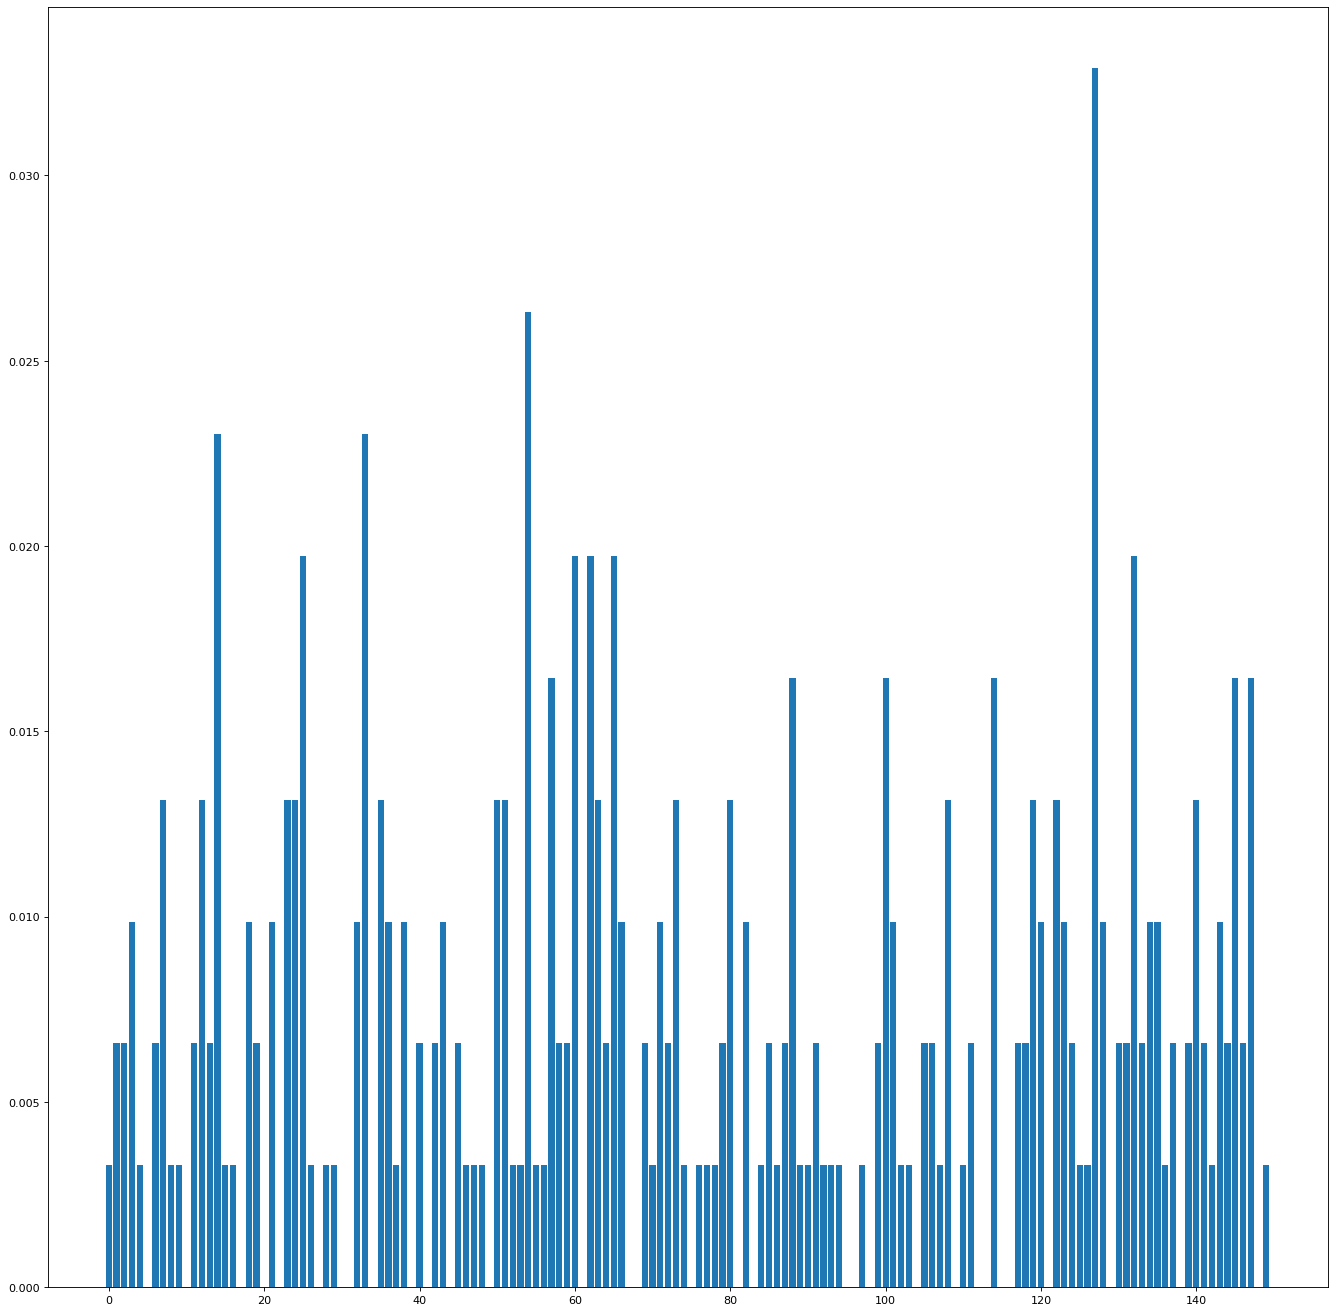

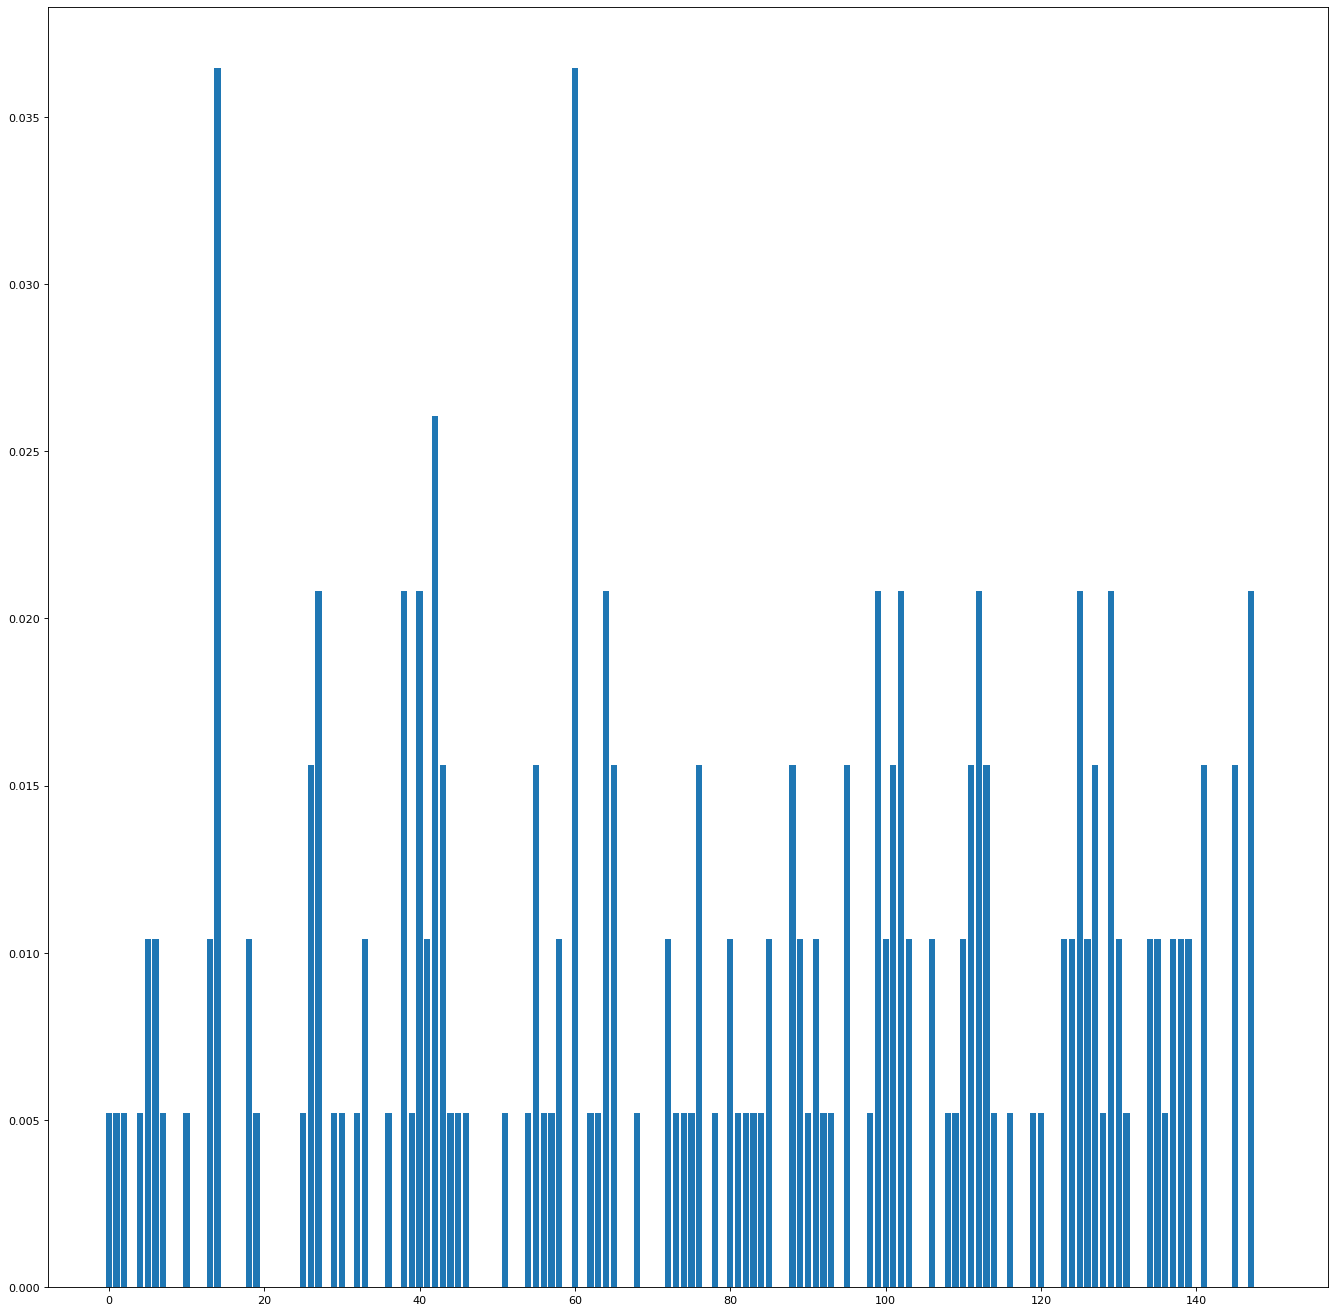

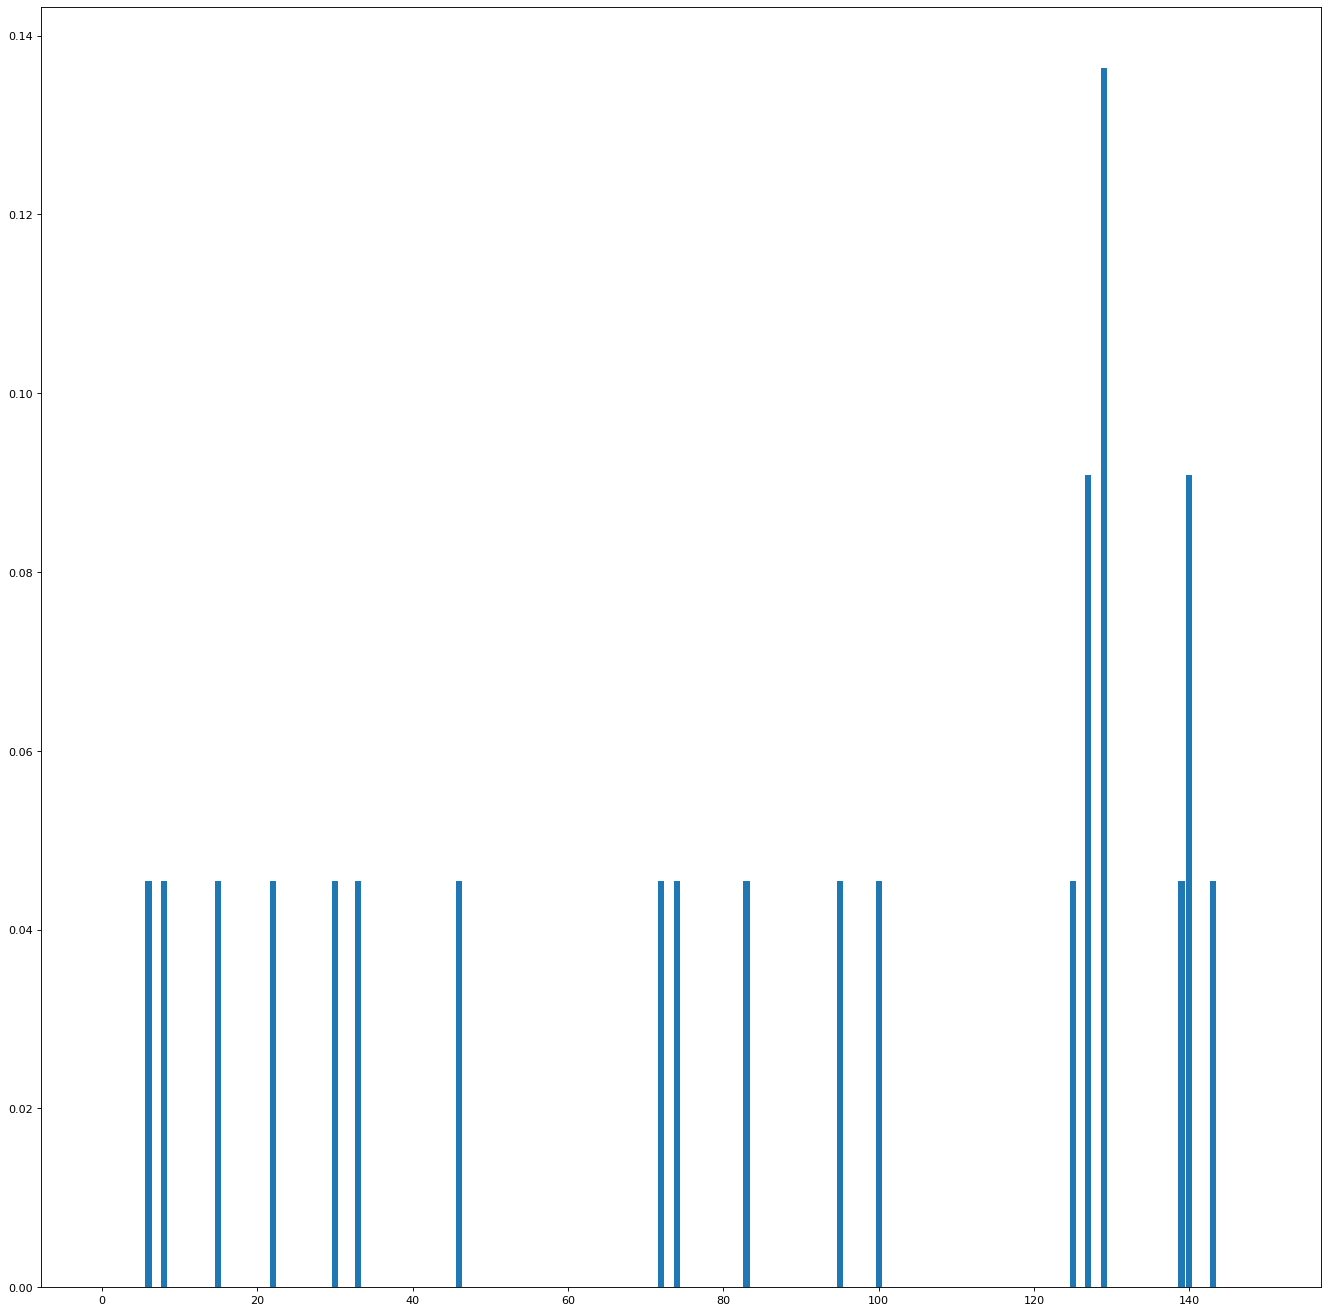

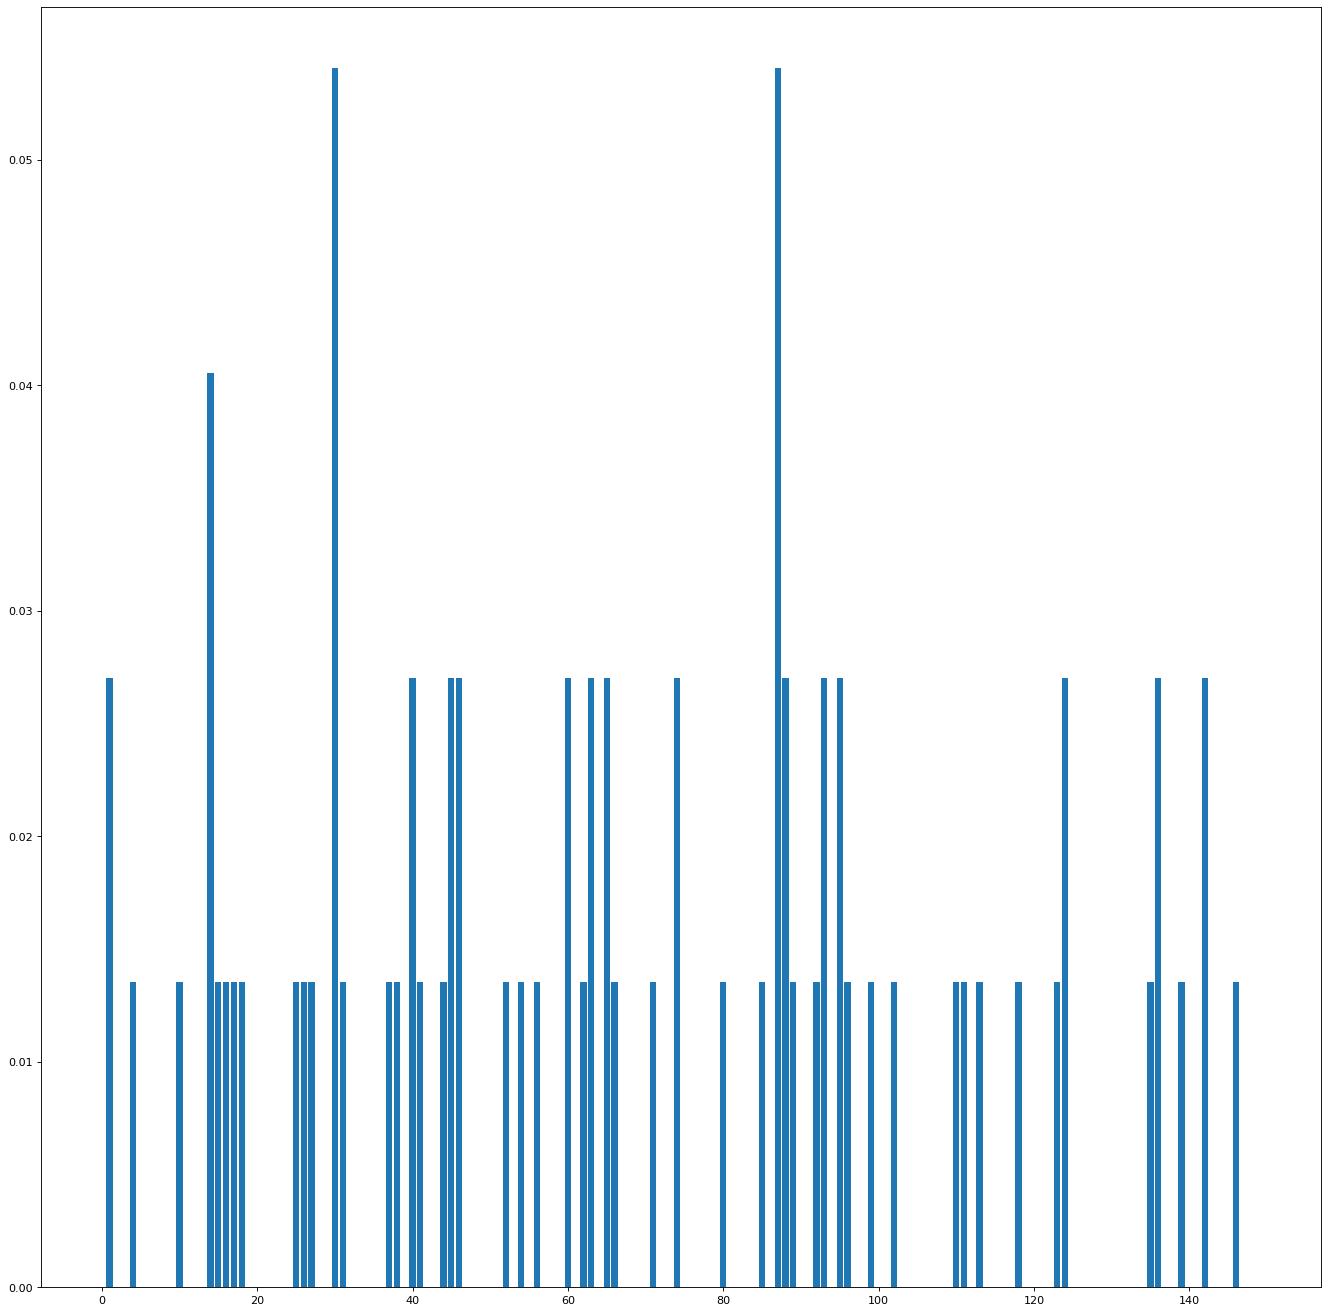

In [150]:
def plot_histogram(pc):
    
#     print(pc)
    fig = plt.figure(figsize = (16,16), dpi = 80)
    ax = fig.add_axes([0,0,1,1])
    langs = range(150)
    students = pc
    ax.bar(langs,students)
    plt.show()
    
for i in range(4):
    plot_histogram(visualization[i])

## Dense SIFT features vs OpenCV SIFT features

We observe a noticeable difference in the way that these methods act on a given image. The Dense SIFT sampling creates a keypoint at every 'patch point', however, the OpenCV implementation only computes feature descriptors on 'interesting' parts of the image. We observe that having so many 'noisy' features when using Dense SIFT hinders the accuracy of our classifier, however, it still does better than the chance accuracy of 12.5%. It also takes longer to compute dense sift features for an image as well as taking longer to perform k-means clustering on - however, this metric varies with the size of the query image.

<table><tr><td><img src='loweSift.png'></td><td><img src='DenseSift.png'></td></tr></table>